## Example: CLD on Sleep and Depressive symptoms
In this example, we  implement a system dynamics model (SDM) analysis of a causal loop diagram (CLD) published as an example in the Education Corner article by Uleman et al (2024) doi: 10.1093/ije/dyae091. This CLD focuses on the feedback loops between sleep and depressive symptoms in young adults.

In Kumu, the diagram looks as follows:

<img src="Kumu/Sleep CLD.jpg" alt="drawing" width="800"/>

To analyze this CLD, we will first run the initialization file, which imports the settings and the Kumu file (should have the same name). We will then run the simulations with what-if scenarios, assess the intervention effects, conduct the feedback loop analysis, and perform sensitivity analysis over the model parameters.

In [1]:
# Initialize the settings and load relevant packages and modules
setting_name = 'Sleep'
%run ../initialize.py {setting_name} {None} 

Test for loading KUMU table passed.
Test comparison with vectorized implementation passed.
Test comparison analytic and numerical solution for linear model passed.
Test comparison with manual implementation for Sleep example passed.


In [2]:
## Print the main simulating settings
for sett in ["N", "time_unit", "t_end", "dt", "variable_of_interest", "max_parameter_value",
             "double_factor_interventions", "solve_analytically"]:
    print(sett, "=", vars(s)[sett])

N = 100
time_unit = Months
t_end = 12
dt = 1
variable_of_interest = Depressive_symptoms
max_parameter_value = 0.2
double_factor_interventions = 0
solve_analytically = 1


Given these settings, we can now run simulations from the SDM-converted CLD.

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


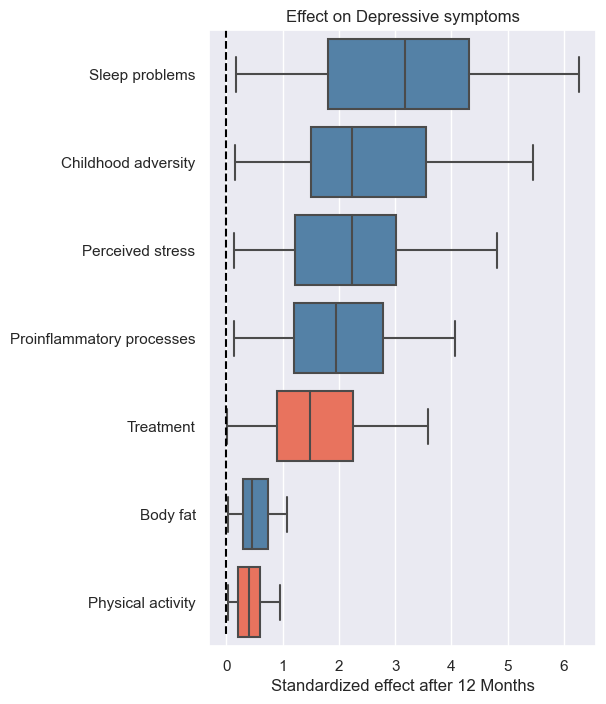

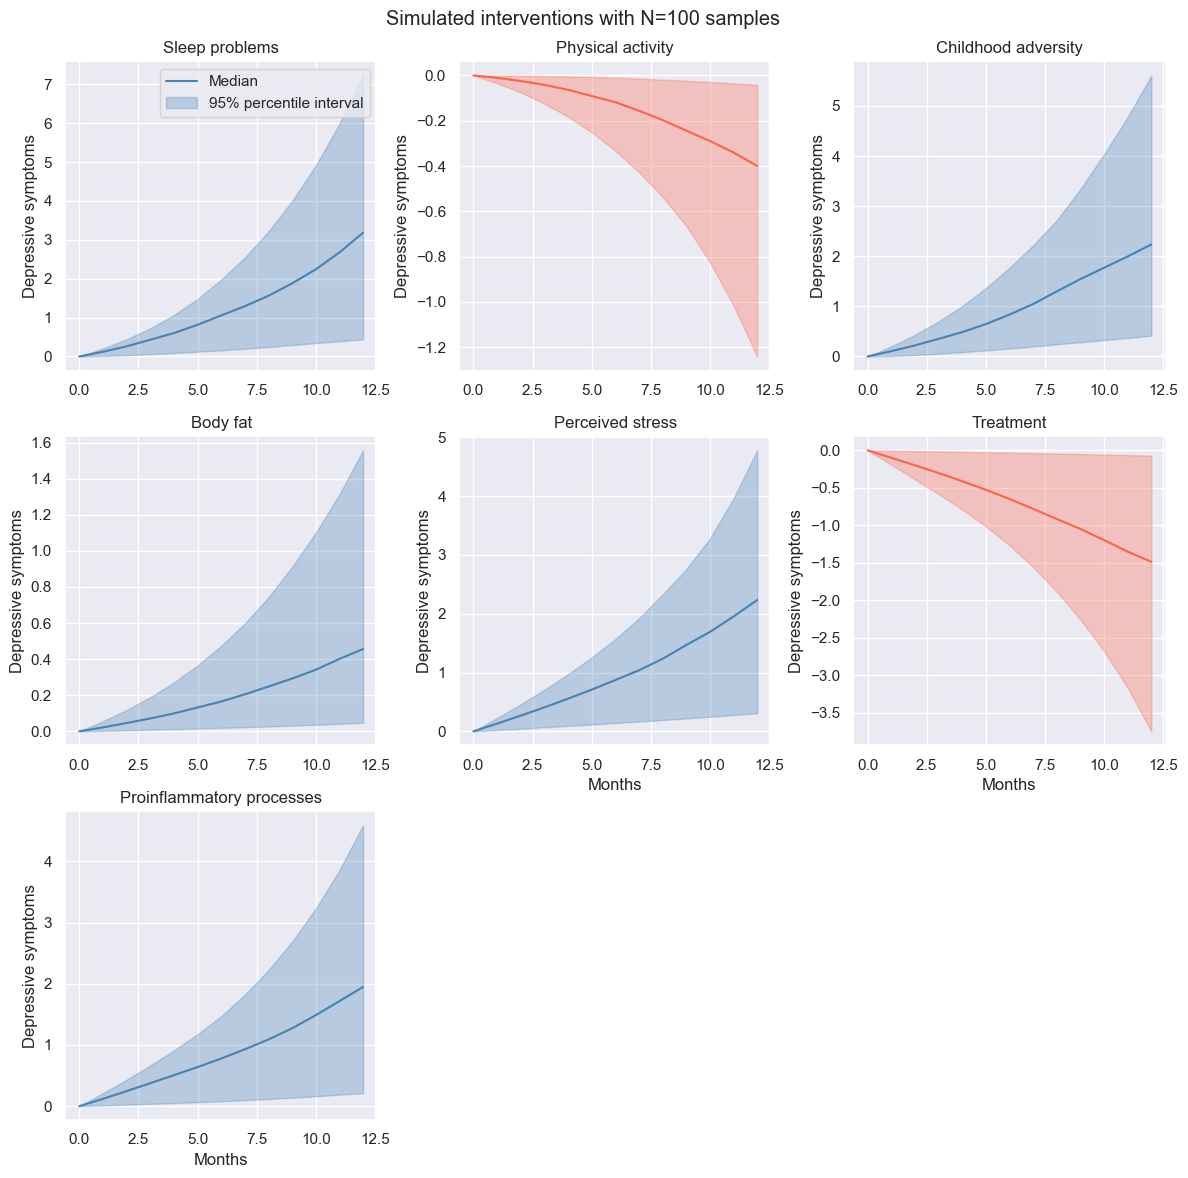

In [3]:
df_sol, param_samples = sdm.run_simulations()  # Run the simulated interventions
intervention_effects = sdm.get_intervention_effects()  # Get the intervention effects
top_plot = None  # Number of top interventions to plot
plot_simulated_intervention_ranking(s, intervention_effects, top_plot=top_plot);  # Plot the simulated interventions ranking
plot_simulated_interventions(s, df_sol, intervention_effects, interval_type="percentile", confidence_bounds=.95, top_plot=top_plot);  # Plot the simulated interventions

## Feedback loop analysis with Loops That Matter
Currently only works correctly for linear SDMs

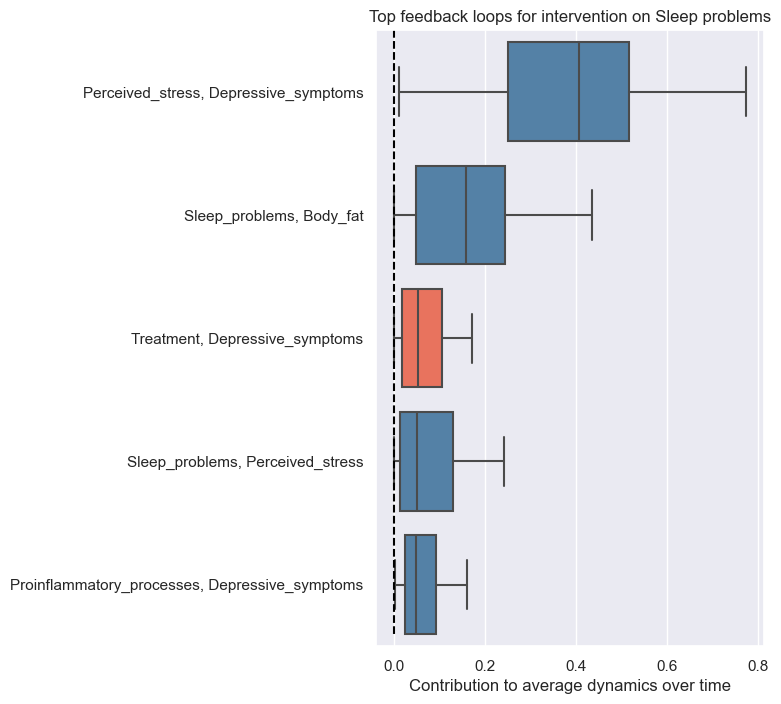

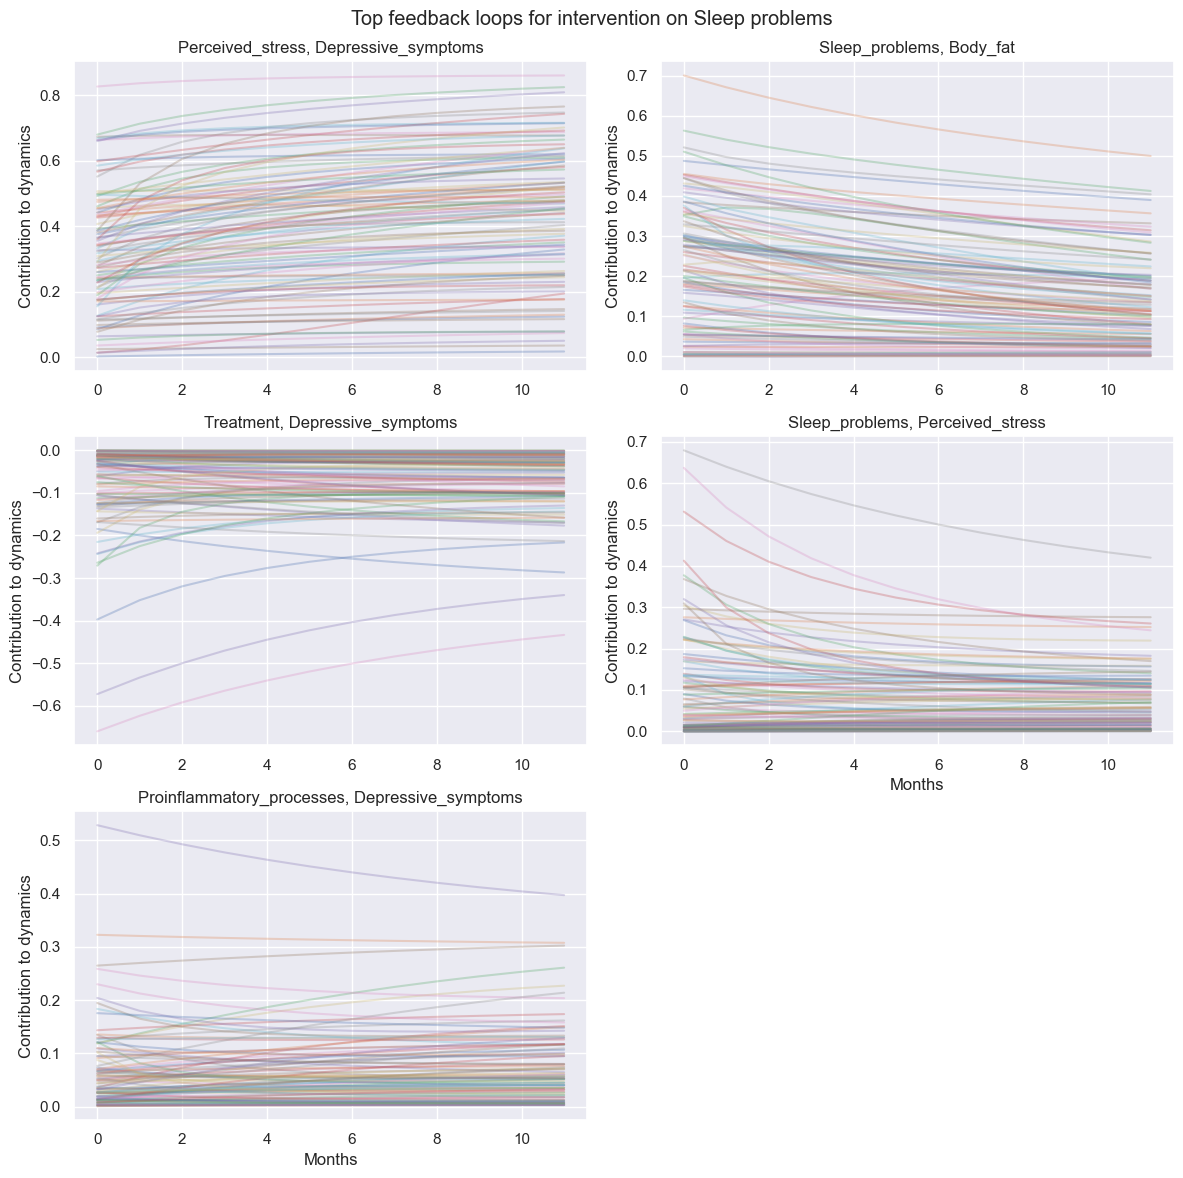

In [4]:
assert s.interaction_terms == False, "Interaction terms must be False for the feedback loop analysis."
int_var = None  # If set to None the highest-ranked intervention variable will be used
df_loops, loopscores_per_sample = sdm.run_loops_that_matter(int_var)  # Run the feedback loop analysis
cut_off_loop_importance = 0.05
plot_feedback_loops_ranking(s, df_loops, intervention_effects, int_var, cut_off_loop_importance);
plot_feedback_loops_over_time(s, df_loops, intervention_effects, loopscores_per_sample, int_var, cut_off_loop_importance);

## Sensitivity analysis

In [5]:
## Estimate spearman correlation for the model parameters, either for one intervention variable (int_var) or for all
cut_off_SA_importance = 0.05
input_var = True  # If True, the top-ranked intervention variable will be used
outcome_var = True  # If True, the variable of interest will be used
SA_results, df_SA = sdm.run_SA(outcome_var, input_var, int_var, cut_off_SA_importance)

Sleep_problems->Depressive_symptoms               0.71
Sleep_problems->Perceived_stress                  0.52
Perceived_stress->Depressive_symptoms             0.38
Depressive_symptoms->Proinflammatory_processes    0.20
Body_fat->Proinflammatory_processes               0.16
Treatment->Depressive_symptoms                    0.14
Physical_activity->Body_fat                       0.13
Sleep_problems->Body_fat                          0.13
Depressive_symptoms->Perceived_stress             0.12
Proinflammatory_processes->Depressive_symptoms    0.12
Body_fat->Sleep_problems                          0.11
Perceived_stress->Sleep_problems                  0.10
Proinflammatory_processes->Sleep_problems         0.06
